In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import scipy
%matplotlib inline

In [2]:
# Read source data
fdelay_raw = pd.read_csv('Flight_Sample_4.csv')

In [3]:
#Data Preview
fdelay_raw.head(4)

,Year,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,DestAirportID,CRSDepTime,DepDelay,DepDel15,CRSArrTime,ArrDelay,ArrDel15,Cancelled
0,2013,7,10,3,DL,10299,13487,1240,-9.0,0.0,2059,-22.0,0,0
1,2013,9,1,7,B6,12889,12954,1519,-5.0,0.0,1625,-14.0,0,0
2,2013,4,10,3,AA,12173,11298,1820,3.0,0.0,655,8.0,0,0
3,2013,8,6,2,UA,13930,11618,945,0.0,0.0,1301,0.0,0,0


In [4]:
fdelay_raw.shape

(108777, 14)

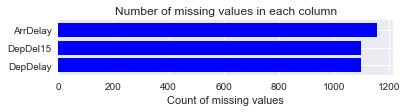

In [5]:
#Explore Missing Values
missing_df = fdelay_raw.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.ix[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(6,1))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()


In [6]:
# Data Type of the columns
dtype_df = fdelay_raw.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df

,Count,Column Type
0,Year,int64
1,Month,int64
2,DayofMonth,int64
3,DayOfWeek,int64
4,Carrier,object
5,OriginAirportID,int64
6,DestAirportID,int64
7,CRSDepTime,int64
8,DepDelay,float64
9,DepDel15,float64


In [7]:
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,10
1,float64,3
2,object,1


In [8]:
#percentage of missing values
missing_df['missing_ratio'] = missing_df['missing_count'] / fdelay_raw.shape[0]
missing_df.ix[missing_df['missing_ratio']>0.001]

,column_name,missing_count,missing_ratio
8,DepDelay,1097,0.010085
9,DepDel15,1097,0.010085
11,ArrDelay,1156,0.010627


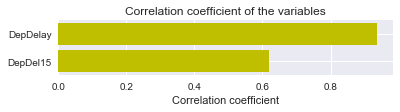

In [9]:
# Let us just impute the missing values with 0 to compute correlation coefficients #
fdelay_raw.fillna(0, inplace=True)
train_df_new = fdelay_raw

# Now let us look at the correlation coefficient of each of these variables #
x_cols = [col for col in train_df_new.columns if col not in ['ArrDelay'] if train_df_new[col].dtype=='float64']

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(train_df_new[col].values, train_df_new.ArrDelay.values)[0,1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')
    
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(6,1))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
#autolabel(rects)
plt.show()

In [10]:
#Let us take the variables with high correlation values and then do some analysis on them.
corr_df_sel = corr_df.ix[(corr_df['corr_values']>0.01) | (corr_df['corr_values'] < -0.01)]
corr_df_sel

,col_labels,corr_values
1,DepDel15,0.620265
0,DepDelay,0.937590


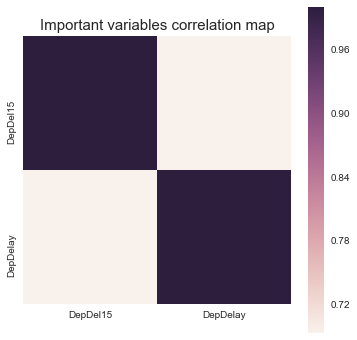

In [11]:
cols_to_use = corr_df_sel.col_labels.tolist()

temp_df = train_df_new[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(6, 6))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True)
plt.title("Important variables correlation map", fontsize=15)
plt.show()

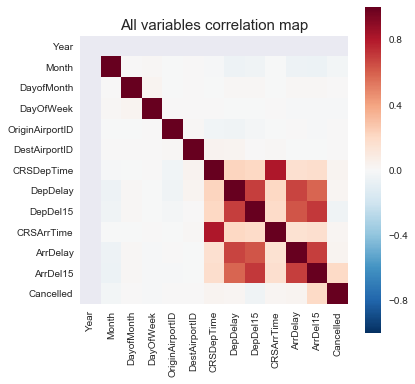

In [12]:
corrmat2 = train_df_new.corr(method='spearman')
f, ax = plt.subplots(figsize=(6, 6))

# Draw the heatmap using seaborn
sns.heatmap(corrmat2, vmax=1., square=True)
plt.title("All variables correlation map", fontsize=15)
plt.show()

In [13]:
def contvar_scatter(df, cols):
    import statsmodels.nonparametric.smoothers_lowess as lw
## Loop over the columns and create the scatter plots
    for col in cols:
## first compute a lowess fit to the data
        los = lw.lowess(df[df.ArrDel15 ==1]['ArrDelay'], df[df.ArrDel15 ==1][col], frac = 0.3)
## Now make the plots
        fig = plt.figure(figsize=(8, 6))
        fig.clf()
        ax = fig.gca()
        df.plot(kind = 'scatter', x = col, y = 'ArrDelay', ax = ax, alpha = 0.05)
        plt.plot(los[:, 0], los[:, 1], axes = ax, color = 'red')
        ax.set_xlabel(col)
        ax.set_ylabel('Arrival Delay')
        ax.set_title('Arriveal Delay vs. ' + col)
    return 'Done'

'Done'

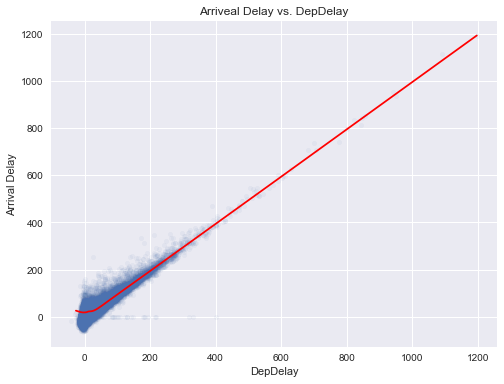

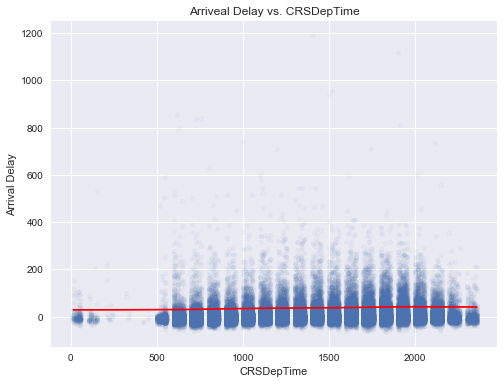

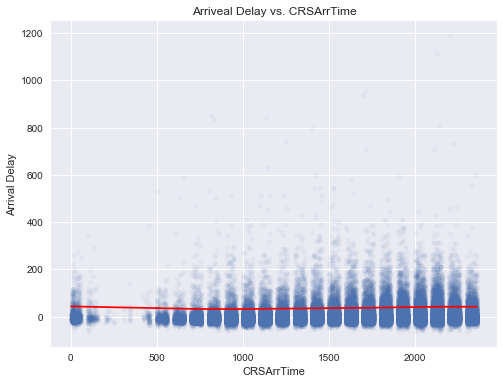

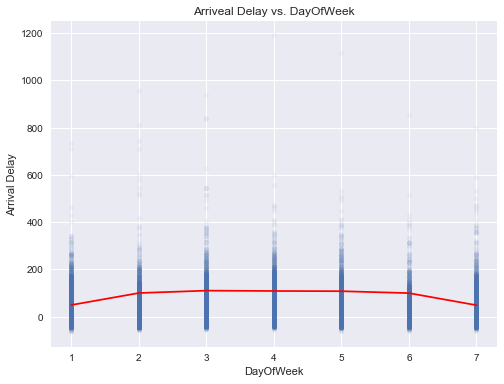

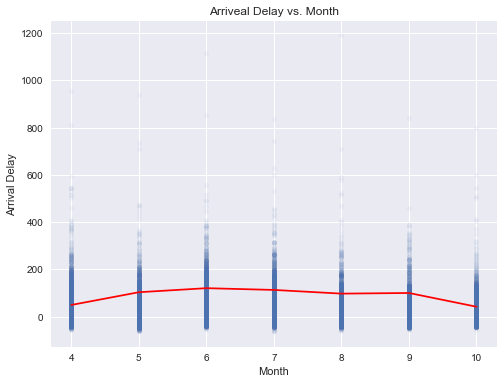

In [14]:
mcols = ['DepDelay', 'CRSDepTime', 'CRSArrTime', 'DayOfWeek','Month'  ]
contvar_scatter(train_df_new,mcols )

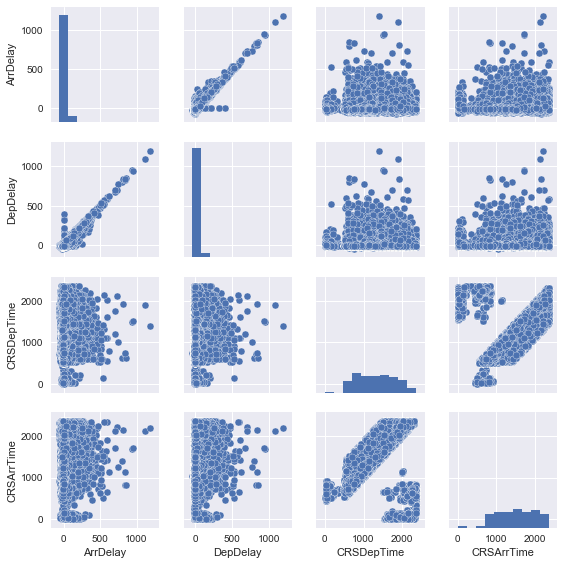

In [15]:
#pair plots
numcols = ['ArrDelay','DepDelay', 'CRSDepTime', 'CRSArrTime' ]
sns.pairplot(train_df_new[numcols], size=2)

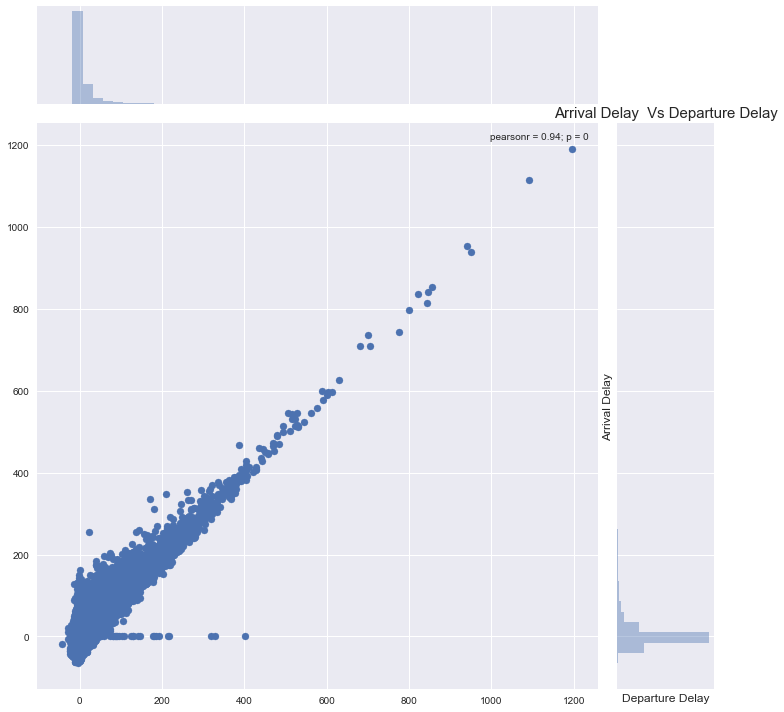

In [16]:
plt.figure(figsize=(10,10))
sns.jointplot(x=train_df_new.DepDelay.values, y=train_df_new.ArrDelay.values, size=10)
plt.ylabel('Arrival Delay', fontsize=12)
plt.xlabel('Departure Delay', fontsize=12)
plt.title("Arrival Delay  Vs Departure Delay", fontsize=15)
plt.show()

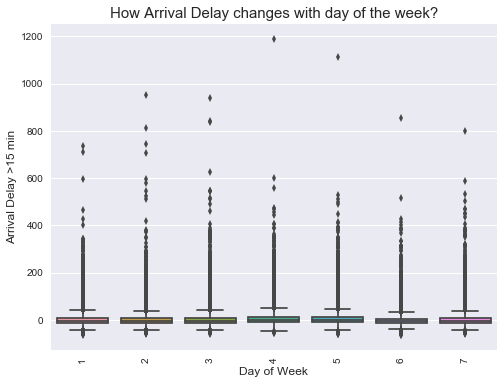

In [17]:
plt.figure(figsize=(8,6))
sns.boxplot(x="DayOfWeek", y="ArrDelay", data=train_df_new)
plt.ylabel('Arrival Delay >15 min', fontsize=12)
plt.xlabel('Day of Week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("How Arrival Delay changes with day of the week?", fontsize=15)
plt.show()

In [18]:
## Function to plot conditioned histograms
def cond_hists(df, plot_cols, grid_col):
    import matplotlib.pyplot as plt
    import seaborn as sns
    ## Loop over the list of columns
    for col in plot_cols:
        grid1 = sns.FacetGrid(df, col=grid_col)
        grid1.map(plt.hist, col, alpha=.7)
    return grid_col

cond_hists(train_df_new, mcols, 'ArrDel15')

'ArrDel15'

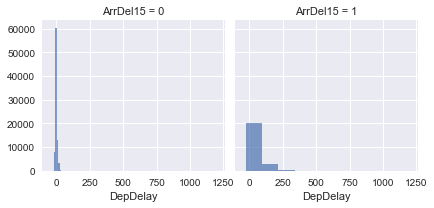

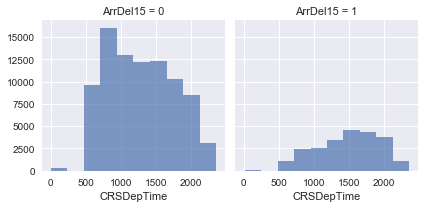

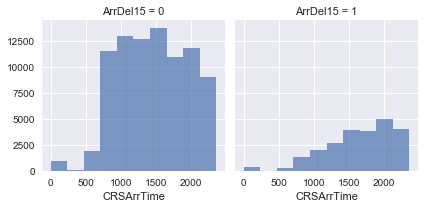

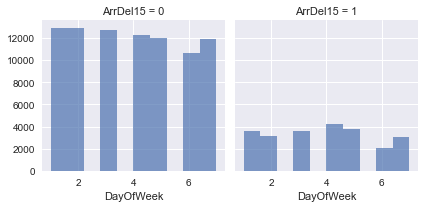

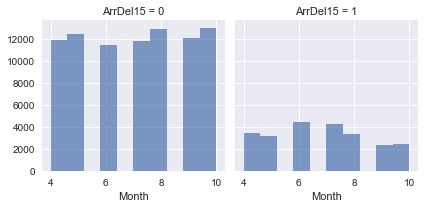

In [19]:
cond_hists(train_df_new, mcols, 'ArrDel15')

In [20]:
def plt_box(df, cols):
#import matplotlib.pyplot as plt
## Loop over the columns and create the box plots
    for col in cols:
        fig = plt.figure(figsize=(8, 6))
        fig.clf()
        ax = fig.gca()
        df.boxplot(column = 'ArrDelay', by = col, ax = ax)
        ax.set_xlabel(col)
        ax.set_ylabel('Arrival Delay')
        ax.set_title('Arrival Delay vs. ' + col)
    return 'Done'

'Done'

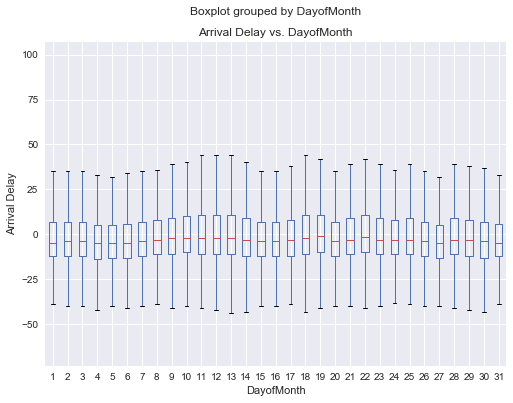

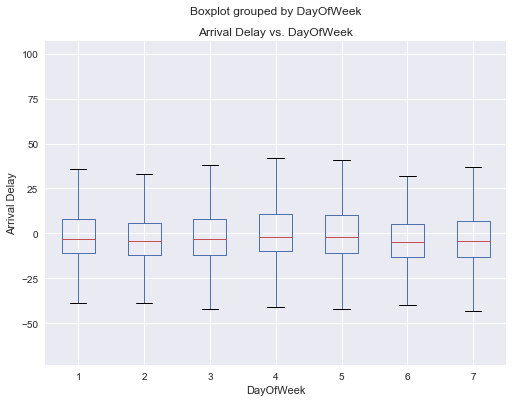

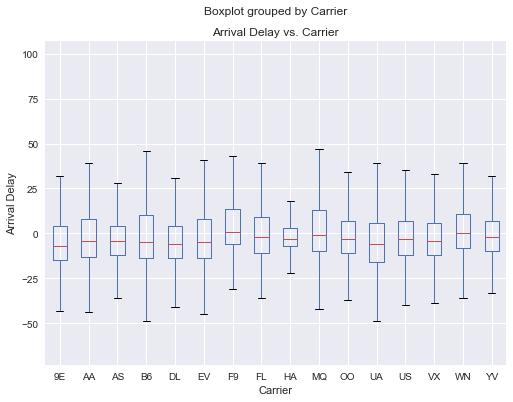

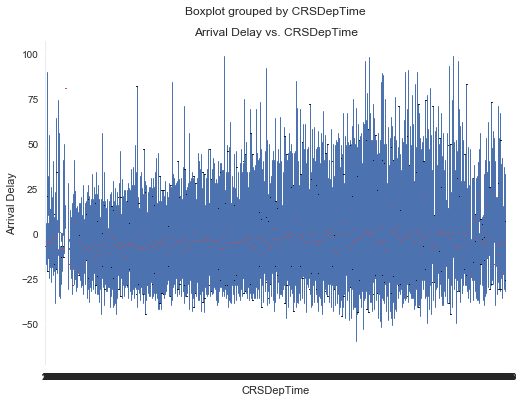

In [21]:
cat_cols = ['DayofMonth', 'DayOfWeek', 'Carrier','CRSDepTime' ]
plt_box(train_df_new[train_df_new.ArrDelay <100], cat_cols )

In [22]:
def plt_hist(df, cols):
#import matplotlib.pyplot as plt
## Loop over columns and plot histograms
    for col in cols:
        fig = plt.figure(figsize=(4, 3))
        fig.clf()
        ax = fig.gca()
        df[col].hist(bins = 30, ax = ax)
        ax.set_xlabel(col)
        ax.set_ylabel('Density of ' + col)
        ax.set_title('Density of ' + col)
    return 'Done'

'Done'

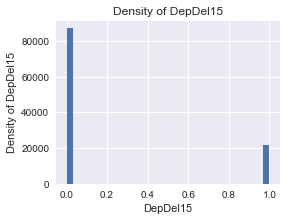

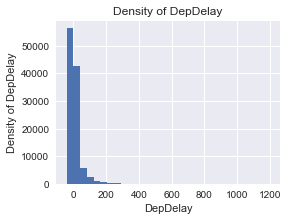

In [23]:
plt_hist(train_df_new, cols_to_use)

In [24]:
# Data Exploration Complete. 
#Now prepare the data for ML by Normalizing the Continous Variables and encoding the 
#categorical variables

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics

# excluding Year, Month,cancelled columns from features as these fields no coorelation to Arrival Delay
# also excluding ArrDelay15 is it deerived field based on Arrival Delay

features = train_df_new[['DayofMonth', 'DayOfWeek', 'Carrier', 'OriginAirportID', 'DestAirportID', 'CRSDepTime', 'DepDelay', 'DepDel15', 'CRSArrTime']]

target = train_df_new['ArrDelay']

#label encoding for carrier
le_carrier = preprocessing.LabelEncoder()
features['Carrier'] = le_carrier.fit_transform(features['Carrier'])

#list of Variables that need to normalized
continous_var = ['CRSDepTime', 'DepDelay','CRSArrTime']
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(features[continous_var])
x_new = pd.DataFrame(x_scaled, columns = continous_var)

rest_of_var = ['DayofMonth', 'DayOfWeek', 'Carrier', 'OriginAirportID', 'DestAirportID', 'DepDel15']

features2 = pd.concat([features[rest_of_var],x_new],axis =1)





C:\Users\FFF4\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [25]:
features = features2
#Split the data into training and test data
X_train,X_test,y_train,y_test = train_test_split(features,target, train_size = 0.8,random_state=123)

In [26]:
# Apply Gradient Boosting Algorithm to create Model

from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor(random_state = 123) # leaving default parameters
reg.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=123, subsample=1.0, verbose=0,
             warm_start=False)

In [27]:
reg.score(X_test,y_test)

0.8738555674752846

In [28]:
predicted_train = reg.predict(X_train)
predicted_test = reg.predict(X_test)
r_sqr = metrics.r2_score(y_test, predicted_test)
mse = metrics.mean_squared_error(y_test, predicted_test)
mae = metrics.mean_absolute_error(y_test, predicted_test)
print(f'Test data r2: {r_sqr:>5.3}')
print(f'Test data mse: {mse:>5.5}')
print(f'Test data mae: {mae:>5.3}')

Test data r2: 0.874
Test data mse: 186.78
Test data mae:  8.98


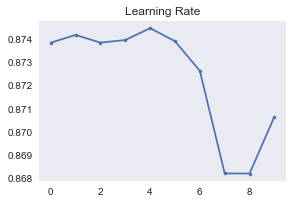

In [29]:
plt.figure(figsize=(15,10))
#Learning Rate
plt.subplot(3,3,2)
feature_param = np.linspace(0.1,1,10)
scores=[]
for feature in feature_param:
    reg = GradientBoostingRegressor(learning_rate=feature)
    reg.fit(X_train,y_train)
    scoreCV = reg.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(scores, '.-')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Learning Rate')
plt.grid();

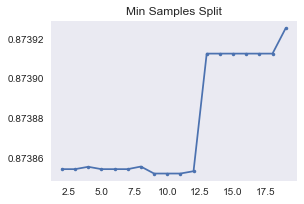

In [31]:
plt.figure(figsize=(15,10))
#Min Samples Split
plt.subplot(3,3,5)
feature_param = range(2,20)
scores=[]
for feature in feature_param:
    reg = GradientBoostingRegressor(min_samples_split =feature)
    reg.fit(X_train,y_train)
    scoreCV = reg.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Min Samples Split')
plt.grid();

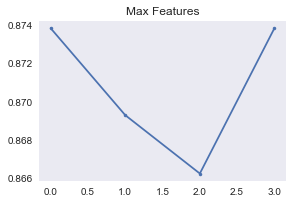

In [32]:
plt.figure(figsize=(15,10))
#Max Features
plt.subplot(3,3,3)
feature_param = ['auto','sqrt','log2',None]
scores=[]
for feature in feature_param:
    reg = GradientBoostingRegressor(max_features=feature)
    reg.fit(X_train,y_train)
    scoreCV = reg.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Max Features')
plt.grid();

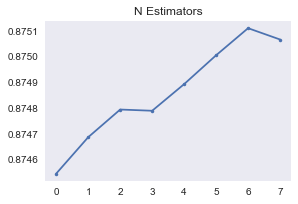

In [33]:
plt.figure(figsize=(15,10))

#N Estimators
plt.subplot(3,3,1)
feature_param = [200,240,260, 280,300, 320,360, 400]
scores=[]
for feature in feature_param:
    reg = GradientBoostingRegressor(n_estimators=feature)
    reg.fit(X_train,y_train)
    scoreCV = reg.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('N Estimators')
plt.grid();


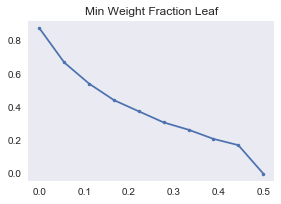

In [34]:
plt.figure(figsize=(15,10))
#Min Weight Fraction Leaf
plt.subplot(3,3,6)
feature_param = np.linspace(0,0.5,10)
scores=[]
for feature in feature_param:
    reg = GradientBoostingRegressor(min_weight_fraction_leaf =feature)
    reg.fit(X_train,y_train)
    scoreCV = reg.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Min Weight Fraction Leaf')
plt.grid();


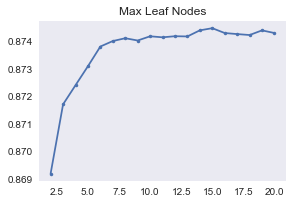

In [35]:
plt.figure(figsize=(15,10))
#Max Leaf Nodes
plt.subplot(3,3,7)
feature_param = range(2,21)
scores=[]
for feature in feature_param:
    reg = GradientBoostingRegressor(max_leaf_nodes=feature)
    reg.fit(X_train,y_train)
    scoreCV = reg.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Max Leaf Nodes')
plt.grid();

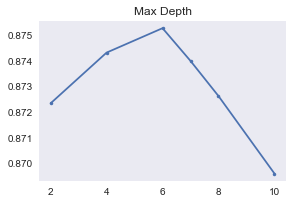

In [36]:
plt.figure(figsize=(15,10))
#Max Depth
plt.subplot(3,3,4)
feature_param = [2,4,6,7,8,10]
scores=[]
for feature in feature_param:
    reg = GradientBoostingRegressor(max_depth=feature)
    reg.fit(X_train,y_train)
    scoreCV = reg.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Max Depth')
plt.grid();

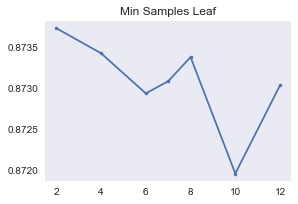

In [37]:
plt.figure(figsize=(15,10))
#Minimum Samples per leaf
plt.subplot(3,3,4)
feature_param = [2,4,6,7,8,10,12]
scores=[]
for feature in feature_param:
    reg = GradientBoostingRegressor(min_samples_leaf=feature)
    reg.fit(X_train,y_train)
    scoreCV = reg.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Min Samples Leaf')
plt.grid();

In [38]:
# parameters and ranges to plot
param_grid1 = {"n_estimators": np.arange(280, 400, 20),
              "max_depth": np.arange(5,9, 1),
              "min_samples_split": np.arange(2,16,2),
              "min_samples_leaf": np.arange(2,8,1),
              "max_leaf_nodes": np.arange(6,15,1),
              "learning_rate": np.arange(0.1,0.5, 0.1),
              "max_features" :['auto', None],
              "min_weight_fraction_leaf": np.arange(0.00,0.05, 0.01)}

In [43]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.grid_search import RandomizedSearchCV

In [44]:
rand = RandomizedSearchCV(reg, param_grid1, cv=10, scoring='r2', n_iter=10, random_state=123)

In [45]:
rand.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=12, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': array([280, 300, 320, 340, 360, 380]), 'max_depth': array([5, 6, 7, 8]), 'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14]), 'min_samples_leaf': array([2, 3, 4, 5, 6, 7]), 'max_leaf_nodes': array([ 6,  7,  8,  9, 10, 11, 12, 13, 14]), 'learning_rate': array([0.1, 0.2, 0.3, 0.4]), 'max_features': ['auto', None], 'min_weight_fraction_leaf': array([0.  , 0.01, 0.02, 0.03, 0.04])},
          pr

In [46]:
rand.grid_scores_

[mean: 0.78230, std: 0.03061, params: {'n_estimators': 280, 'min_weight_fraction_leaf': 0.02, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_leaf_nodes': 14, 'max_features': None, 'max_depth': 7, 'learning_rate': 0.30000000000000004},
 mean: 0.81915, std: 0.02598, params: {'n_estimators': 340, 'min_weight_fraction_leaf': 0.01, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_leaf_nodes': 10, 'max_features': 'auto', 'max_depth': 5, 'learning_rate': 0.4},
 mean: 0.82007, std: 0.02575, params: {'n_estimators': 360, 'min_weight_fraction_leaf': 0.01, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_leaf_nodes': 10, 'max_features': 'auto', 'max_depth': 6, 'learning_rate': 0.1},
 mean: 0.88498, std: 0.01026, params: {'n_estimators': 280, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_leaf_nodes': 11, 'max_features': None, 'max_depth': 5, 'learning_rate': 0.1},
 mean: 0.72023, std: 0.02974, params: {'n_estimators': 320, 'min_weight_fraction_leaf

In [47]:
# examine the best model
print(rand.best_score_)
print(rand.best_params_)
print(rand.best_estimator_)

0.8849840757375997
{'n_estimators': 280, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_leaf_nodes': 11, 'max_features': None, 'max_depth': 5, 'learning_rate': 0.1}
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=11, min_impurity_split=1e-07,
             min_samples_leaf=2, min_samples_split=8,
             min_weight_fraction_leaf=0.0, n_estimators=280,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)


In [48]:
reg = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=11, min_impurity_split=1e-07,
             min_samples_leaf=2, min_samples_split=8,
             min_weight_fraction_leaf=0.0, n_estimators=280,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [49]:
reg.fit(X_train,y_train)
reg.score(X_test,y_test)
predicted_test = reg.predict(X_test)
mse = metrics.mean_squared_error(y_test, predicted_test)
mae = metrics.mean_absolute_error(y_test, predicted_test)
print(f'Test data mse: {mse:>5.5}')
print(f'Test data mae: {mae:>5.3}')

Test data mse: 185.02
Test data mae:  8.92


In [50]:
reg.score(X_test,y_test)

0.8750467294070469

In [54]:
reg2 = GradientBoostingRegressor( learning_rate=0.1,criterion='friedman_mse',  max_depth=6, max_features=None,
             max_leaf_nodes=14, min_weight_fraction_leaf=0, n_estimators=400, random_state=123)

In [55]:
reg2.fit(X_train,y_train)
print('score :', reg2.score(X_test,y_test))
predicted_test = reg2.predict(X_test)
mse = metrics.mean_squared_error(y_test, predicted_test)
mae = metrics.mean_absolute_error(y_test, predicted_test)
print(f'Test data mse: {mse:>5.5}')
print(f'Test data mae: {mae:>5.3}')

score : 0.8752910887655203
Test data mse: 184.66
Test data mae:   8.9
